<a href="https://colab.research.google.com/github/girijesh-ai/prompt-design/blob/main/CoRise_Week2_StudentVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This notebook is part of the course: [Prompt Design & Building AI products](https://corise.com/course/prompt-design-building-ai-products) and is created by Sidharth Ramachandran as the project for Week 2 of the course.

# Generate album covers for a podcast

Welcome to the project that is part of Week 2 of the course - Prompt Design & Building AI products. In this project, you are going to choose a podcast episode of your choice & generate an album cover that is relevant and attractive for listeners.

The entire project is divided into the following steps:

*   Understand the content and context of the podcast to design an appropriate cover image
*   Design prompts for image generation models to generate multiple cover image versions
*   Understand different ways in which image generation can be done using prompts, existing images, scribbles and much more.

# The Problem

The cover art of a podcast is the first thing that a user will view when landing on the podcast page or searching on any pocast player. Having a well designed and attractive podcast cover image can help to attract eyeballs and potentially a larger audience.

You might have noticed that most podcasts have a standard cover image which is then repeated for every listed episode. While this ensures recognition of a common brand, it can also be repetitive and boring. One of the reasons for this is because designing and generating cover images for every podcast episode can be tedious and time-consuming. Especially when you are not an artist or don't have easy access to one. Let's try to build an AI product that provides a service to generate cover images for any given podcast episode.

# Section 1 - Understand podcast content to determine the right cover image

Good cover images are attractive and paint a picture of what the user can expect to hear in that podcast. In order to generate these images, we must first try to figure out what the episode is about and what is being discussed.

There are several ways in which you can get information about the podcast:

- Using the title of the podcast episode
- Using the episode description or show notes
- Using transcripts to identify key highlights or generating a summary

### Installing necessary libraries

Before proceeding further, let's take the opportunity to install the necessary libraries. We will make use of OpenAI (for prompting chatGPT) and Diffusers (this is a library from Huggingface that allows us to use several StableDiffusion based models for image generation).

In [1]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.5 MB/s eta 0:00:00


In [2]:
import openai
from getpass import getpass

openai.api_key = getpass('Enter your OPENAI_API_KEY  ')

Enter your OPENAI_API_KEY  ··········


In [3]:
!pip install -Uq diffusers transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.1/989.1 kB 9.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.2 MB/s eta 0:00:00


In [4]:
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 4.8 MB/s eta 0:00:00


In [5]:
from diffusers import DiffusionPipeline
import torch
from huggingface_hub import notebook_login
from PIL import Image

In order to make use of HuggingFace, it's necessary to first create an [account](https://huggingface.co/), and agreeing to the Terms & Conditions. Once that is complete then please run the below cell which will provide you with a link to your HuggingFace account where you can copy the token. Once you copy-paste it here then you will be able to pull and use many of the models that are hosted on HuggingFace hub.

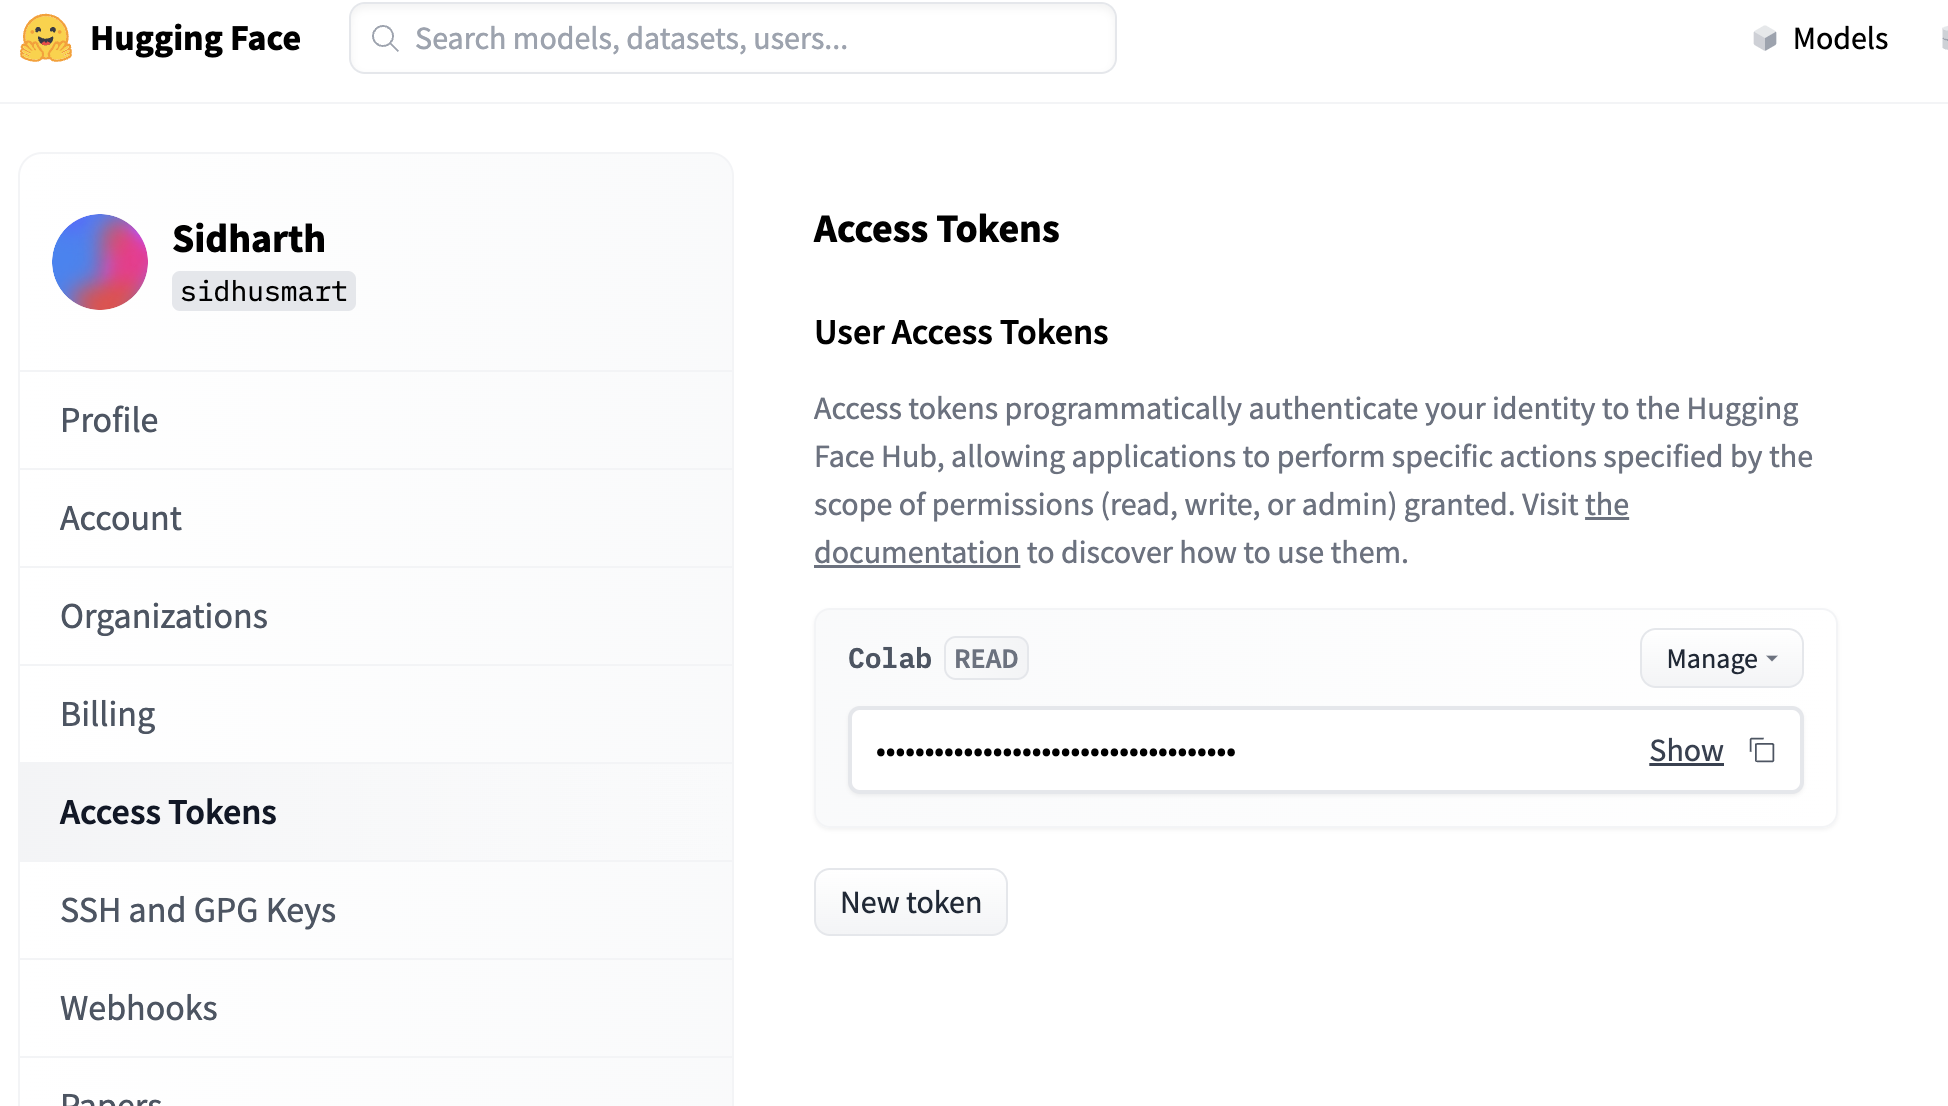

In [6]:
notebook_login()

## Setting up Stable Diffusion functions

We will use StableDiffusion as our image generation model. This is an open-source model and allows us to control parameters allowing us to generate an image again if required. StableDiffusion is available in multiple versions with the latest being SDXL 1.0. The way that each model is used varies and we will provide three functions below as follows -

1. generate_sdv14_image - this function uses StableDiffusion v1.4 to generate images. It is relatively low on GPU usage and should work faster than the other two functions.
2. generate_sdxl_base_image - this function uses SDXL 1.0 - the latest version released a month ago. This uses only the base model to generate images and requires higher GPU usage and take more time.
3. generate_sdxl_refined_image - this function uses both the Base and Refiner models that are part of SDXL and requires significantly more memory and run-time.

Keep in mind that SDXL is a larger model that offers better image quality and prompt instructions but also requires more memory and takes longer to generate images. SD v1.4 on the other hand required more work on prompt design but is a smaller model that runs faster allowing you to experiment more. The quality of images generated and the level of effort involved in prompting the model is directly propotional to the GPU memory required.

⚠️⚠️⚠️ **Important Information** ⚠️⚠️⚠️

The cells below have functions defined for each of the StableDiffusion models. Please **DO NOT** try to load and run all the functions within the same notebook. Google Colab will only be able to handle one model variant being loaded in GPU memory at a time. If you do want to experiment with multiple models, we would recommend that you run a separate Colab instance for each StableDiffusion function.

### **Stable Diffusion v1.4**

In [7]:
# Download the StableDiffusion v1.4 model
sd_v14 = DiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", force_download=True, resume_download=False).to("cuda")
sd_v14.enable_attention_slicing()

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [8]:
def generate_sdv14_image(prompt, seed=42):
  torch.manual_seed(seed)
  return sd_v14(prompt).images[0]

### **SDXL 1.0 Base Model**

In [ ]:
from diffusers import DiffusionPipeline
import torch

base_sdxl = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
base_sdxl.to("cuda")
base_sdxl.enable_attention_slicing()

In [ ]:
def generate_sdxml_base_image(prompt, seed=42):
  torch.manual_seed(seed)
  return base_sdxl(prompt).images[0]

### **SDXL 1.0 - Base + Refiner Model**

In [ ]:
from diffusers import DiffusionPipeline
import torch

# Download the base model first
base_sdxl = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0",
                                         torch_dtype=torch.float16,
                                         use_safetensors=True,
                                         variant="fp16",
                                         force_download=True,
                                         resume_download=False)
base_sdxl.to("cuda")
base_sdxl.enable_attention_slicing()

# Download the refiner model next
refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base_sdxl.text_encoder_2,
    vae=base_sdxl.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
refiner.enable_attention_slicing()
refiner.enable_model_cpu_offload()

In [ ]:
def generate_sdxl_refined_image(prompt, seed=42):
  torch.manual_seed(seed)

  # How to employ the mixture of experts model
  n_steps = 40
  high_noise_frac = 0.8

  # Run the base first
  image = base_sdxl(
      prompt=prompt,
      num_inference_steps=n_steps,
      denoising_end=high_noise_frac,
      output_type="latent",
  ).images

  # Run the refiner next
  image = refiner(
      prompt=prompt,
      num_inference_steps=n_steps,
      denoising_start=high_noise_frac,
      image=image,
  ).images[0]

  return image

We enable the CPU offload function only for the Refiner model. This is important because otherwise we risk overloading the CPU memory and can lead to the Colab notebook crashing.

⚠️⚠️⚠️ **Important Information** ⚠️⚠️⚠️

Based on the model and function that you choose to work with, please replace all the below cells with that function! By default, we have set this to `generate_sdv14_image` as that should run easily with the default GPU provided in the free tier of Google Colab.

## Generating podcast cover images

In order to generate possible cover images, please experiment with some techniques, models and prompts. Depending on the episode that you chose, you can determine the prompt using just the title, description or the transcription. Please choose a method that fits your choice and gives you best results.

When working with image generators, make sure that you are setting a random seed that allows you to replicate the image that you like. This is an important capability that is possible only with open-source models like StableDiffusion.

## Using episode titles

You can use the episode title direcly in the prompt or with any added prefix of your choice, for e.g. `Podcast cover image of ...`

  0%|          | 0/50 [00:00<?, ?it/s]

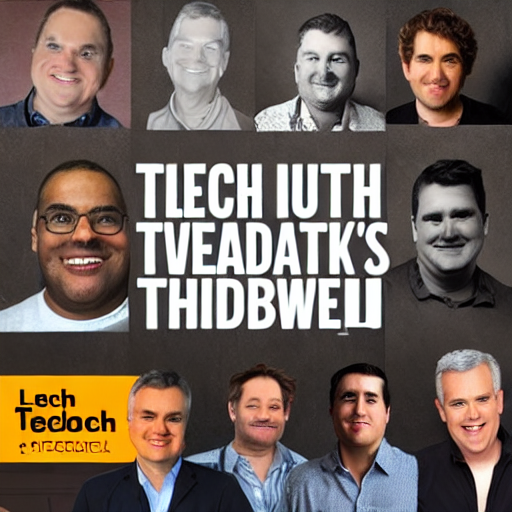

In [12]:
image_seed = 42
prompt = "Create Podcast cover image of the famous tech podcast 'This Week in Tech' hosted by Leo Laporte"
generate_sdv14_image(prompt, seed=image_seed)

You can easily generate multiple versions of this image by simply changing the random seed.

  0%|          | 0/50 [00:00<?, ?it/s]

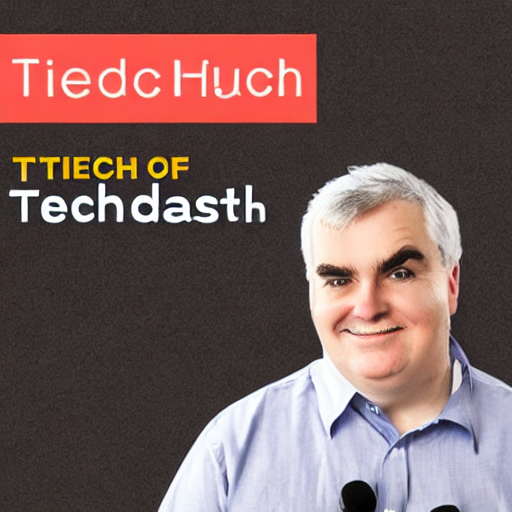

In [13]:
image_seed = 2100
prompt = "Create Podcast cover image of the famous tech podcast 'This Week in Tech' hosted by Leo Laporte"
generate_sdv14_image(prompt, seed=image_seed)

You can also use the below function that randomly chooses 4 different seeds and displays the generated images in a grid to provide you with an initial set of options. You can also run this function multiple times to generate further image outputs. This will take a bit longer as we are generating more images.

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def generate_images(input_prompt):
  images = []
  for i in range(2):
    for j in range(2):
      seed_value = np.random.randint(0, 2**32 - 1)
      print (seed_value)
      image = generate_sdv14_image(input_prompt, seed_value)
      images.append(image)

  fig, axes = plt.subplots(2, 2, figsize=(8, 8))

  for i, image in enumerate(images):
        row, col = i // 2, i % 2
        axes[row, col].imshow(image)
        axes[row, col].axis('off')
  plt.show()

1130489910


  0%|          | 0/50 [00:00<?, ?it/s]

2950805269


  0%|          | 0/50 [00:00<?, ?it/s]

3284452824


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


1753667540


  0%|          | 0/50 [00:00<?, ?it/s]

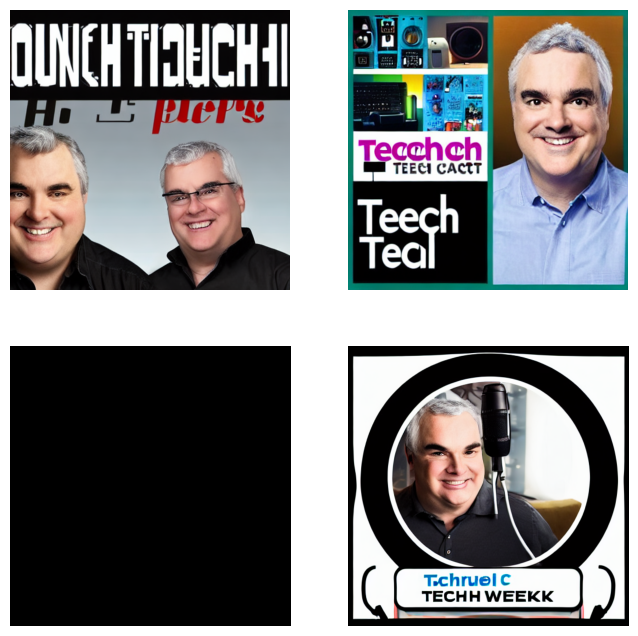

In [15]:
# Call the function to generate and display the images
generate_images("Create Podcast cover image of the famous tech podcast 'This Week in Tech' hosted by Leo Laporte")

Please note the main findings from your experiments at this stage:

*   Did you notice any weird artifacts in the generated images?
*   Did you run into any errors? Were you able to correct them?
*   Do you try multiple generations with different random seeds - are some themes consistent across all generations?


### Use podcast episode description and show notes

Since episode titles may not be fully reflective of the episode, you can try to go a step further and retrive information from the description and show-notes of the podcast. A good source to look for this information is the RSS feed of the podcast. It is how most podcasts are distributed, listed and updated. Specifically, we are interested in the *description* section.

As an example, you can look-up the RSS feed for the Lex Fridman podcast - https://lexfridman.com/feed/podcast/ and it looks something as shown below:

---


<description>Sam Altman is the CEO of OpenAI, the company behind GPT-4, ChatGPT, DALL-E, Codex, and many other state-of-the-art AI technologies. Please support this podcast by checking out our sponsors:
- NetSuite: http://netsuite.com/lex to get free product tour
- SimpliSafe: https://simplisafe.com/lex
- ExpressVPN: https://expressvpn.com/lexpod to get 3 months free

EPISODE LINKS:
Sam&#039;s Twitter: https://twitter.com/sama
OpenAI&#039;s Twitter: https://twitter.com/OpenAI
OpenAI&#039;s Website: https://openai.com
GPT-4 Website: https://openai.com/research/gpt-4

PODCAST INFO:
Podcast website: https://lexfridman.com/podcast
Apple Podcasts: https://apple.co/2lwqZIr
Spotify: https://spoti.fi/2nEwCF8
RSS: https://lexfridman.com/feed/podcast/
YouTube Full Episodes: https://youtube.com/lexfridman
YouTube Clips: https://youtube.com/lexclips

SUPPORT &amp; CONNECT:
- Check out the sponsors above, it&#039;s the best way to support this podcast
- Support on Patreon: https://www.patreon.com/lexfridman
- Twitter: https://twitter.com/lexfridman
- Instagram: https://www.instagram.com/lexfridman
- LinkedIn: https://www.linkedin.com/in/lexfridman
- Facebook: https://www.facebook.com/lexfridman
- Medium: https://medium.com/@lexfridman

OUTLINE:
Here&#039;s the timestamps for the episode. On some podcast players you should be able to click the timestamp to jump to that time.
(00:00) - Introduction
(08:41) - GPT-4
(20:06) - Political bias
(27:07) - AI safety
(47:47) - Neural network size
(51:40) - AGI
(1:13:09) - Fear
(1:15:18) - Competition
(1:17:38) - From non-profit to capped-profit
(1:20:58) - Power
(1:26:11) - Elon Musk
(1:34:37) - Political pressure
(1:52:51) - Truth and misinformation
(2:05:13) - Microsoft
(2:09:13) - SVB bank collapse
(2:14:04) - Anthropomorphism
(2:18:07) - Future applications
(2:21:59) - Advice for young people
(2:24:37) - Meaning of life</description>


---

Depending on how the description of your chosen podcast is structured, it may contain information that is not necessary like sponsored links, social media links, podcast reader links etc. We are only interested in retrieving the actual content of the episode that we could use in our image generation prompt, so please determine how you might do that using an LLM.

Please complete the following prompts to obtain a summary of the podcast using chatGPT starting from the description of the podcast.

In [21]:
instructPrompt = """
 One of the famous and widely recognized tech podcasts is "This Week in Tech" (TWiT), hosted by Leo Laporte. It covers a wide range of technology-related topics, including discussions about the latest tech news, gadgets, software, and industry trends. TWiT has been a prominent tech podcast for many years and features a variety of guest experts and commentators from the tech world.
"""

In [22]:
podcast_description = """
Guests: Nicholas Deleon, Dan Moren, Iain Thomson
Category: News
Thousands stuck in mud at Burning Man festival
Australia and Texas overturn laws requiring age verification for adult websites
Right to repair advocates score victory in California with Apple now supporting it
NFT sales and prices plummeting showing the downfall of the once-hyped digital assets
Twitter to lift ban on political ads ahead of 2024 election
Social media companies failing to curb Russian propaganda says EU report
Arkansas law requiring parental consent for minors' social media accounts blocked by judge
Congress working on protecting minors on social media but raises privacy concerns
Barbie film leaks online ahead of official release showing persistence of piracy
NFL, NBA, UFC want faster DMCA takedowns to combat live streaming of games
Gannett admits AI-written local sports stories were "hilariously terrible"
Department of Defense launches website for tracking UFOs/UAPs
Georgia election interference trial for Trump to be livestreamed on YouTube
Google killing Pixel Pass after just 22 months despite promise of ongoing new phones
Microsoft retiring WordPad after 28 years
Cruise self-driving cars causing problems by blocking emergency vehicles in San Francisco
Download or subscribe to this show at https://twit.tv/shows/this-week-in-tech

Get episodes ad-free with Club TWiT at https://twit.tv/clubtwit
"""

In [23]:
requestMessage = instructPrompt + '\n' + podcast_description

In [24]:
chatOutput = openai.ChatCompletion.create(model="gpt-3.5-turbo",
                                          messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                    {"role": "user", "content": requestMessage}
                                                      ]
                                          )

In [25]:
episodeSummary = chatOutput.choices[0].message.content
print (episodeSummary)

Thank you for sharing the information about the latest episode of "This Week in Tech" (TWiT) podcast. It seems like there are several interesting topics being discussed, ranging from technology news to social media and internet issues. If you're interested in listening to this episode or other episodes of TWiT, you can download or subscribe to the show at https://twit.tv/shows/this-week-in-tech.

Additionally, if you want to enjoy episodes ad-free, you can consider becoming a member of Club TWiT at https://twit.tv/clubtwit. This membership allows you to access episodes without any advertisements.

I hope you find this information helpful, and enjoy listening to "This Week in Tech"!


You can now try the podcast summary directly in an image prompt with the necessasry prefix. Please try to generate images using the summary using your image prompt.

Token indices sequence length is longer than the specified maximum sequence length for this model (156 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['https :// twit. tv / shows / this - week - in - tech. additionally, if you want to enjoy episodes ad - free, you can consider becoming a member of club twit at https :// twit. tv / clubtwit. this membership allows you to access episodes without any advertisements. i hope you find this information helpful, and enjoy listening to " this week in tech "!']


2787019726


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['https :// twit. tv / shows / this - week - in - tech. additionally, if you want to enjoy episodes ad - free, you can consider becoming a member of club twit at https :// twit. tv / clubtwit. this membership allows you to access episodes without any advertisements. i hope you find this information helpful, and enjoy listening to " this week in tech "!']


1206494292


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['https :// twit. tv / shows / this - week - in - tech. additionally, if you want to enjoy episodes ad - free, you can consider becoming a member of club twit at https :// twit. tv / clubtwit. this membership allows you to access episodes without any advertisements. i hope you find this information helpful, and enjoy listening to " this week in tech "!']


3140166610


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['https :// twit. tv / shows / this - week - in - tech. additionally, if you want to enjoy episodes ad - free, you can consider becoming a member of club twit at https :// twit. tv / clubtwit. this membership allows you to access episodes without any advertisements. i hope you find this information helpful, and enjoy listening to " this week in tech "!']


4148441275


  0%|          | 0/50 [00:00<?, ?it/s]

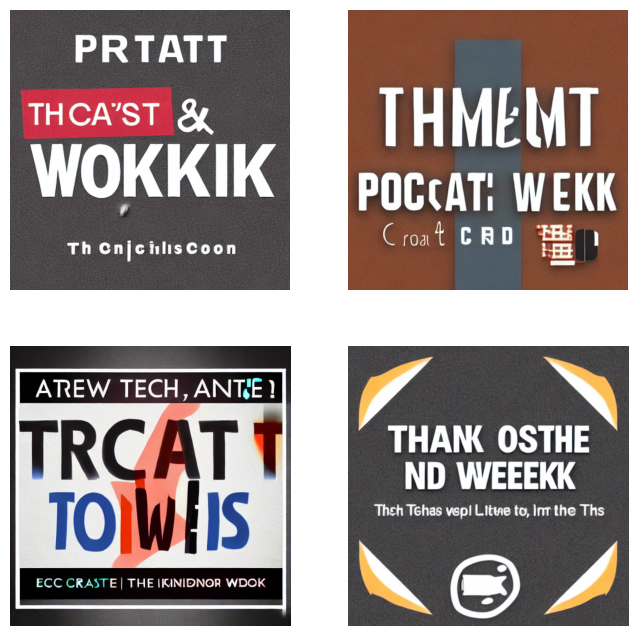

In [26]:
generate_images("Create podcast episode cover image based on {}".format(episodeSummary))

Please note the main findings from your experiments at this stage:

*   Did you notice any weird artifacts in the generated images?
*   Did you run into any errors? Were you able to correct them?
*   Do you try multiple generations with different random seeds - are some themes consistent across all generations?


## Generating a design brief based on the podcast episode

You can also use the help of the LLM to generate ideas for a cover image. Instead of letting the image generation model infer what you want, you can try to imagine a visualization and then provide specific descriptions to generate something that you like.

In the below section, please design prompts that will try to use chatGPT in a brainstorming exercise to design the podcast cover.

In [37]:
instructPrompt = """
You are a create graphic designer who will create images based on given description, please give me the idea how would you design a cover poster for this episode summary in less that 50 words.
"""

In [38]:
requestMessage = instructPrompt + '\n' + episodeSummary

In [39]:
chatOutput = openai.ChatCompletion.create(model="gpt-3.5-turbo",
                                          messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                    {"role": "user", "content": requestMessage}
                                                      ]
                                          )

In [40]:
imagePrompt = chatOutput.choices[0].message.content

Depending on how you design your prompt, you may not have exactly what you need in one API call. It might require some back-n-forth to generate an image prompt that you like and which works. Depending on how you design and structure your prompts, you may have to make additional calls to the LLM to go from a design idea to an image generation prompt.

Once you have the prompt that looks satifactory, do try to use it directly and generate images so that you can test the workflow completely.

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["'s name and episode number along with a collage of technology symbols and social media icons. this design will capture the essence of the podcast's diverse and engaging topics, enticing potential listeners to tune in."]


2673515854


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["'s name and episode number along with a collage of technology symbols and social media icons. this design will capture the essence of the podcast's diverse and engaging topics, enticing potential listeners to tune in."]


2057445824


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["'s name and episode number along with a collage of technology symbols and social media icons. this design will capture the essence of the podcast's diverse and engaging topics, enticing potential listeners to tune in."]


3701484896


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["'s name and episode number along with a collage of technology symbols and social media icons. this design will capture the essence of the podcast's diverse and engaging topics, enticing potential listeners to tune in."]


2561544536


  0%|          | 0/50 [00:00<?, ?it/s]

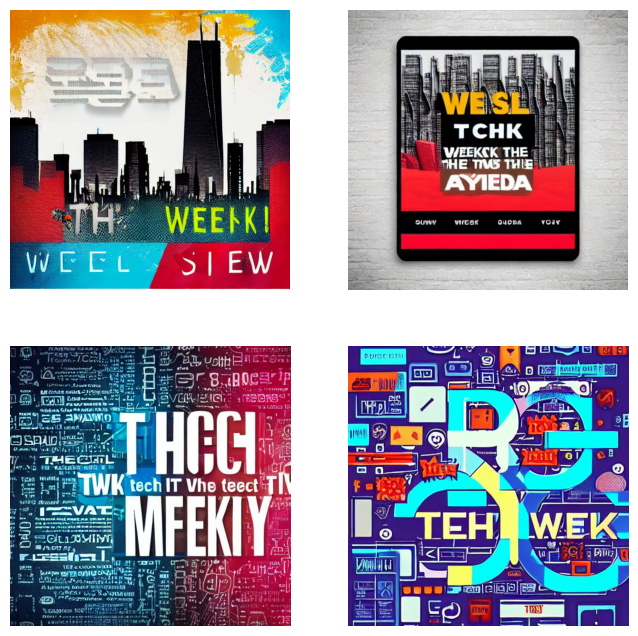

In [41]:
generate_images(imagePrompt)

We have established a sort of workflow and before looking for ways to improve the genrated images, let's look at one other way to obtaining podcast episode information - transcription!

### Using podcast transcripts

Depending on the podcast that you choose, it's possible that the Title and description of the podcast are missing or there isn't enough information to accurately paint a picture of the podcast. This is where a transcript can prove very helpful as it is much more detailed. Using a transcript also has some other benefits which we will list in the bonus section.

In this section, we will generate transcripts from a podcast and use that for generating cover images. A great example to test this scenario could be the podcast that you generated in Week 1. In that case, we did not create a Title or Description and we can use the transcript to generate an cover image for that episode.

We will use the OpenAI Whisper Speech to Text model to generate the transcript from any podcast. This model works quite well and is also capable of translating to English from many languages and performs with high accuracy. We could therefore use this technique to generate cover images for podcasts in other languages as well!

We need to get the MP3 file of the podcast and the download URL is found in the RSS feed of the podcast. For example, the download URL for the Lex Fridman episode with Sam Altman is found in the RSS feed as shown below:

---

`<enclosure url="https://media.blubrry.com/takeituneasy/content.blubrry.com/takeituneasy/lex_ai_sam_altman.mp3" length="106661376" type="audio/mpeg" />`

---

You may already have the mp3 file from the Week 1 project which you can upload to the Google Colab folder but you could also use the command `!wget <download_url>` to get the podcast episode of your choice.

We perform the necessary steps to install Whisper and load the `medium` size model that we will use for the transcription.

In [ ]:
!pip install git+https://github.com/openai/whisper.git  -q

In [ ]:
import os
import whisper

model = whisper.load_model("medium")

In [ ]:
result = model.transcribe("PATH_TO_PODCAST_AUDIO_FILE")

You can briefly take a look and confirm that the generated transcript matches with the podcast and that it can be used to generate our image prompts.

In [ ]:
result["text"]

The transcript can be quite long and we need to boil it down to a summary with the help of chatGPT. In the previous section, we took help of chatGPT to remove unecessary characters and elements from the episode description. In this section, you need to modify the prompt to work with a transcript instead.

In [ ]:
instructPrompt = """
YOUR_PROMPT_HERE
"""

requestMessage = instructPrompt + '\n' + result["text"]

chatOutput = openai.ChatCompletion.create(model="gpt-3.5-turbo",
                                          messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                    {"role": "user", "content": requestMessage}
                                                      ]
                                          )

episodeSummary = chatOutput.choices[0].message.content

In [ ]:
episodeSummary

We can follow the same steps as the previous section to brainstorm design ideas using the LLM. Depending on how you design these set of prompts, you might have to make more than one call. At the end, use the `generate_images` function to test the prompts provided by the LLM.

In [ ]:
instructPrompt = """
YOUR_PROMPT_HERE
"""

requestMessage = instructPrompt + '\n' + episodeSummary

chatOutput = openai.ChatCompletion.create(model="gpt-3.5-turbo",
                                          messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                    {"role": "user", "content": requestMessage}
                                                      ]
                                          )

imagePrompt = chatOutput.choices[0].message.content

In [ ]:
generate_images(imagePrompt)

Hopefully, by now you have a set of images that are a reasonable starting point and can be further enhanced. It's quite amazing to see what is possible just with the help of a few lines of text. At the same time, these images are not perfect and hopefully you made a note of these.


In the following section, you will dive into a more detailed prompt for our images and determine various ways in which we can structure the prompt by making use of modifiers, special words, artist names and also some further technical parameters and see if we can actually move towards generating WOW images!

# Model Prompting Techniques

1. Specifying the type of image
2. Identifying the subject
3. Jazzing up the image with modifiers and styles
4. Adding modifiers, special effects, negative keywords etc.

### Step 1: Clearly specifying what is the type of image you want:
 - A photo, digital illustration, oil painting etc.

In the beginning we used the term `Podcast cover image with ...  <scene_description>`. In later steps, we asked chatGPT to create prompts as a junior designer and ended with prompts that started with - `Create image of .. <scene_description>`.

However, it's important to state the type of image we want in more specific terms that the models can understand. You can try using some examples such as `movie poster`, `photo`, `digital illustration`, `painting`

In the section below, we have adapted the `generate_images` function to `generate_variants` that takes a base_prompt and a list of additional modifiers and generates two images for each combination to see the effect of various types of keywords.

By default, the index parameter is set to 0. This will keep the base_prompt constant and add the variants at the end of the prompt. Passing any other index values will reverse the order of the combination.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

  def generate_variants(base_prompt, variants, index=0):
    images = []
    for i in range(len(variants)):
      for j in range(2):
        torch.manual_seed(np.random.randint(0, 2**32 - 1))
        if (index == 0):
          image = generate_sdv14_image(base_prompt + variants[i], seed)
        else:
          image = generate_sdv14_image(variants[i] + base_prompt, seed)
        images.append(image)

    fig, axes = plt.subplots(len(variants), 2, figsize=(8, 8))

    for i, image in enumerate(images):
          row, col = i // 2, i % 2
          axes[row, col].imshow(image)
          axes[row, col].axis('off')
    plt.show()

Use the last image prompt that you have to define a very simple `base_prompt` that keeps only one main element that you would like to see in the podcast cover. This would be the main subject of your image.

Then define the list of image types/ art types that you would like to experiment with - essentially you are creating the image in a certain style of art.

In [ ]:
base_prompt = "YOUR_BASE_PROMPT_HERE"
generate_variants(base_prompt, ['MEDIUM_STYLE_1','MEDIUM_STYLE_2','MEDIUM_STYLE_3'], index=1)

You should be able to see the effect of various styles showing up in the image output. This forms the first and important part of our choice of what type of image we would like to see.

### Step 2 - Identifying the subject

The next step is the choice of subject (what we had fixed in our base_prompt so far). You might think that the subject is very clear to you but it may not be so clear to the model. Or, there might be other words that provide a much better result than the one you had originally chosen.

A great resource that you can use to understand this would be [Lexica](https://lexica.art/). You can search for the image ideas in your mind and find similar images generated by users and get clues for the subject words you want to include. Please ensure to filter the search results for "Stable Diffusion" as that is the model we are using.

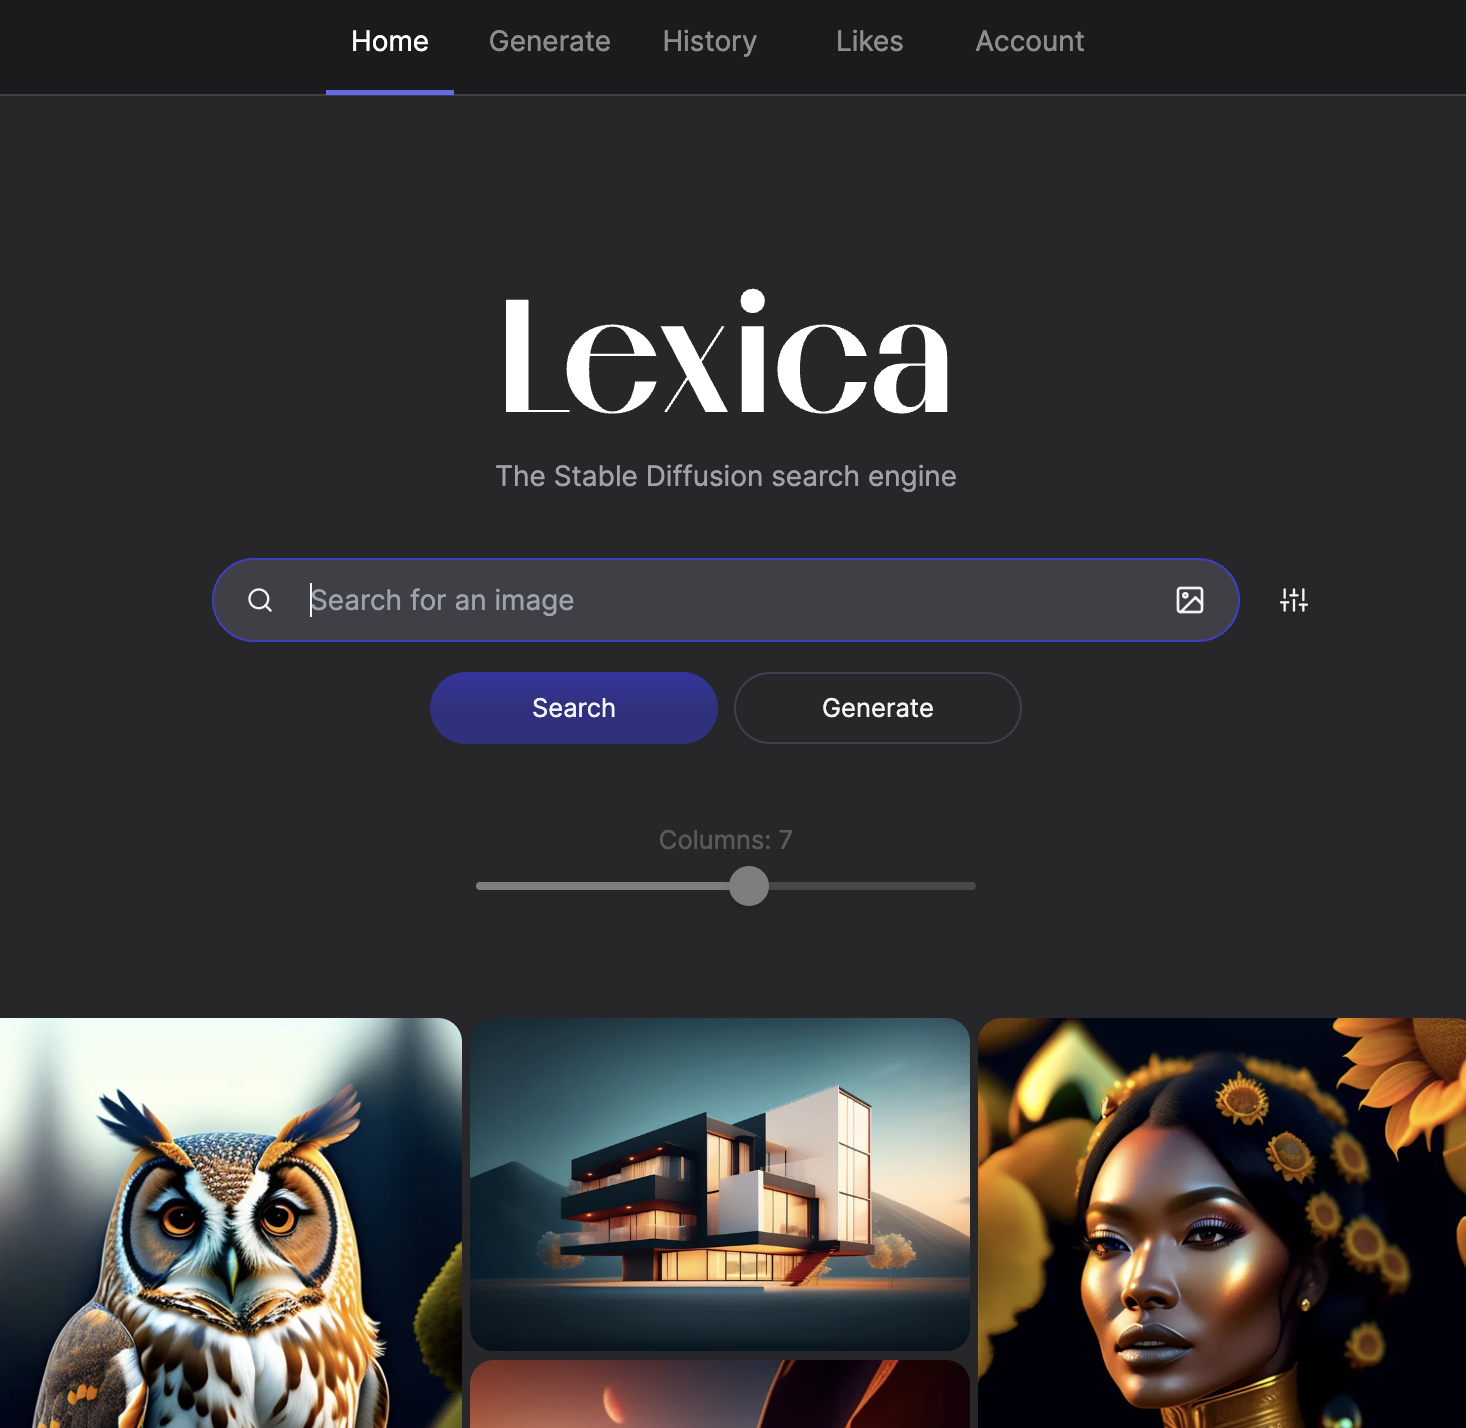

In [ ]:
base_prompt = "YOUR_CHOSEN_IMAGE_TYPE"
generate_variants(base_prompt, ['SUBJECT_OPTION_1','SUBJECT_OPTION_2','SUBJECT_OPTION_2'])

You should be able to find a good combination of your subject and the type of image you want by now. Please iterate with different seeds to check if you are able to come up with more interesting variants.

### Step 3 - Jazzing up the image with lighting and style modifiers

The images might still look plain and now is when we include other elements that can bring our image alive. As you are looking up the images in Lexica, you might notice the use of additional keywords signifying the type of lighting - `spotlight`, `diffused`, `volumetric lighting` etc. Additionally, there might be scene descriptors that you did not add yet - is there a specific place or location where the subject should be - `indoor`, `in the sky` or something specific in the background of the image - `huge crowd`, `snow-capped mountains`.

We are trying to paint a fuller picture at this stage but making sure our subject is highlighted correctly and is in the right environment.

In [ ]:
base_prompt = "YOUR_NEW_BASE_PROMPT"
generate_variants(base_prompt, ['MODIFIER_1','MODIFIER_2','MODIFIER_3'])

It's not necessary that the results work well with your first attempt. It may also be possible that you have already decided your MEDIUM_STYLE so you do not need to provide a list. Feel free to adapt the `generate_variants` function to test the different keywords that you are experimenting with.

### Step 4 - Adding keywords, special effects, negative keywords etc.

We are now very close to how our image should look like and this stage is where we can choose from a variety of additional keywords that denote special effects. For example, you can specify what type of lens or and shot you would like which can drastically affect the quality and look and feel of the image. This stage is one of the most important learnings when working with StableDiffusion - **addition of modifiers is really important to get high-quality images**.

You can add many other types of modifiers to make the images pop. Some of these include

- image descriptors like `4K`, `hyperrealistic`, `highly detailed`
- shot types like `product shot`, `potraits`
- art medium types like `water colors`, `oil painting`, `artwork`
- artists like `Alejandro Bursido`, `Ansel Adams`, `Emerson Tung`
- mood/feeling descriptors like `gloomy`, `vibrant`, `historic`

We are firmly in experimentation mode. The best image is purely subjective and can involve a lot of hit & trial. For the podcast cover please try with various options and see what works in your case.

In [ ]:
base_prompt = "YOUR_BASE_PROMPT"
generate_variants(base_prompt, ['KEYWORD_1','KEYWORD_1','KEYWORD_1'])

At this point you might also notice that adding too many modifiers doesn't make as much impact. So while the use of modifiers is very important, stuffing your prompt with them is also not sensible.

This leads us to another important principle - **Order Matters**. The weight of a token at the beginning of a sentence is much larger than a token towards the end. So when designing prompts, ensure that the most important elements of the desired image is placed further ahead and other types of modifiers and styles are placed towards the end.

#### **Note**: Negative keywords

Many times, the generated image can have artifacts like ill-formed limbs, garbled text etc. You can make use of the `negative_prompt` argument to pass in additional keywords that you would not like to see in the images. You can do that in the following way (we did not include this in the `generate_variants` function itself)

In [ ]:
torch.manual_seed("CHOSEN_SEED")
pipe(prompt="YOUR_CHOSEN_PROMPT", negative_prompt="YOUR_NEGATIVE_KEYWORDS").images[0]

# Exploring alternate ways of generating images - differently-trained models

So far we were working our way to better images via the use of modifiers and other keywords in our prompt. This is not the only way to get better images. We can also generate better images by making use of a better base model!

StableDiffusion itself has several model versions - v1.4, v1.5, v2.1. As the model and weights are open-source there is a large community that has also re-trained or fine-tuned models starting with the base version of StableDiffusion. For example, a custom model trained on more images of automobiles will be able to better generate images of cars and motorbikes. There are several locations where you can find these models on [HuggingFace](https://huggingface.co/models?library=diffusers&sort=downloads) and [CIVITAI](https://civitai.com/).

The easiest way to load a different model would be to continue with the Diffusers library and only make a change in the path name of the model that you would like to use. You can choose a model of your preference or experiment with multiple options to see if you like the generated images better. Feel free to reuse the `generate_images` or `generate_variants` functions with the new model as well.

In [ ]:
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained("YOUR_MODEL_PATH", torch_dtype=torch.float16).to("cuda")

In [ ]:
pipe.enable_attention_slicing()

In [ ]:
torch.manual_seed(21)
prompt = "YOUR_IMAGE_PROMPT"
pipe(prompt).images[0]

In addition, there are other private image models like DALL-E and MidJourney that are also very good at generating images but make use of an API or Discord based interface. I will demo some examples of this during the kick-off session as it's not something that works easily from within a Colab notebook.

# Bonus Section



## chatGPT Prompt Designer

You can see that the techniques we used follow a trial-and-error approach. It's not clear which set of keywords work better in generating a good image and also identifying what is **good** is not easy. It's best to leave this to the host of the podcast or an editor to make a selection from multiple options.

How should we make this a product?

In the following section, we will make use of chatGPT to assist us in prompt generation. Our goal is to write a function that can generate multiple options variants of images that could fit as the cover image of a podcast episode. Once that is done, we can provide these options to an editor to make a selection or generate more variants in that particular style.

You start by adapting chatGPT to perform the role of a prompt engineer. You have to ask it follow a formula and we can keep providing it with different types of subjects, art mediums and generate multiple image prompts.

Depending on how you design the prompt, you might also have to make multiple calls to the LLM in this section. Please design a function that uses the LLM to generate multiple prompts and then generate a set of images that can be presented to a human editor for review and selection.

In [ ]:
instructPrompt = """
YOUR_PROMPT_HERE
"""
chatOutput = openai.ChatCompletion.create(model="gpt-3.5-turbo",
                                          messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                    {"role": "user", "content": instructPrompt}
                                                      ]
                                          )

imagePrompt = chatOutput.choices[0].message.content
generate_images(imagePrompt)

**Task**: Can you define a generic function that combines various ways to understand episode content and generate images using different prompts to provide a selection of options for an editor to choose from?

## Generate a podcast logo

One of the latest developments in the image synthesis space is a model called ControlNet. This model gives one the ability to upload a sketch or rough version of a painting and by making use of text instructions guide the generation towards what you would like. This is an advanced use case but those who are interested can attempt to create a logo for your podcast by using this technique.

It makes use of the AUTOMATIC1111 WebUI (which will be briefly demo'ed during the kick-off) and can be loaded by following the links below.

You can follow these links to setup your own instance of the WebUI using [Google Colab](https://colab.research.google.com/github/TheLastBen/fast-stable-diffusion/blob/main/fast_stable_diffusion_AUTOMATIC1111.ipynb) or other providers as decribed in the [Github](https://github.com/TheLastBen/fast-stable-diffusion) repo.